## Import libraries

In [1]:
import satlas.util
import torchvision
import json 
import torch 
import skimage.io
import satlas.model.model
import satlas.model.evaluate
import numpy as np
import tqdm
from PIL import Image, ImageDraw, ImageFont
import cv2
from osgeo import gdal
from skimage.measure import find_contours
import satlaspretrain_models
import rasterio
from rasterio.windows import Window
import json
import numpy as np
import os, os.path
import rasterio.features
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix
import shapely
import skimage.draw
import skimage.morphology
import satlas.model.dataset
import satlas.util
from skimage.morphology import skeletonize
import random
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from torchvision.ops import nms

In [114]:
# def simplify_polygon(mask, tolerance=2.0):
#     """Simplify polygon using Douglas-Peucker Algorithm."""
#     contours = find_contours(mask, 0.5)
#     polygons = []
#     for contour in contours:
#         # Bỏ qua contour không đủ điểm
#         if len(contour) < 4:
#             continue
#         poly = Polygon(contour[:, ::-1])  # Đảo ngược trục (y, x) -> (x, y)
#         if poly.is_valid and poly.area > 100:  # Lọc polygon nhỏ
#             simplified_poly = poly.simplify(tolerance, preserve_topology=True)
#             if simplified_poly.is_valid and simplified_poly.area > 100:
#                 polygons.append(simplified_poly)
#     return unary_union(polygons) if polygons else None

# def apply_nms(out, iou_threshold=0.5):
#     """
#     Áp dụng Non-Maximum Suppression (NMS) cho các đa giác trong output.
#     """
#     boxes = out['boxes']  # (N, 4) - bounding boxes
#     scores = out['scores']  # (N,) - confidence scores
#     masks = out['masks']
#     # Áp dụng NMS
#     keep_indices = nms(boxes, scores, iou_threshold)

#     # Lọc các đối tượng được giữ lại
#     out['boxes'] = boxes[keep_indices]
#     out['labels'] = out['labels'][keep_indices]
#     out['scores'] = scores[keep_indices]
#     out['masks'] = masks[keep_indices]

#     return out

# def regularize_polygon(polygon, grid_size=1.0, angle_tolerance=5.0):
#     """Regularize the edges of a polygon to align with straight lines or right angles."""
#     if polygon.is_empty or not isinstance(polygon, Polygon):
#         return polygon  # Skip empty or non-polygon geometries

#     def snap_to_grid(coord, grid_size):
#         return round(coord / grid_size) * grid_size

#     def snap_coords_to_grid(coords, grid_size):
#         return [(snap_to_grid(x, grid_size), snap_to_grid(y, grid_size)) for x, y in coords]

#     snapped_coords = snap_coords_to_grid(list(polygon.exterior.coords), grid_size)

#     def regularize_angle(p1, p2, p3, angle_tolerance):
#         v1 = np.array(p1) - np.array(p2)
#         v2 = np.array(p3) - np.array(p2)
#         angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
#         angle = np.degrees(angle) % 180

#         if abs(angle - 90) <= angle_tolerance or abs(angle - 180) <= angle_tolerance:
#             return p2  # Already aligned
#         else:
#             avg_x = (p1[0] + p3[0]) / 2
#             avg_y = (p1[1] + p3[1]) / 2
#             return (snap_to_grid(avg_x, grid_size), snap_to_grid(avg_y, grid_size))

#     regularized_coords = []
#     coords = snapped_coords
#     for i in range(len(coords) - 2):
#         p1, p2, p3 = coords[i], coords[i + 1], coords[i + 2]
#         p2 = regularize_angle(p1, p2, p3, angle_tolerance)
#         regularized_coords.append(p2)

#     regularized_coords.append(regularized_coords[0])  # Close the polygon
#     return Polygon(regularized_coords)

# def polygonize_masks(masks, boxes):
#     polygons = [[] for _ in masks]

#     for box_idx, (mask, box) in enumerate(zip(masks, boxes)):
#         mask = (mask > 0.5).astype(np.uint8)

#         # We use rasterio for initial polygonization and rastachimp for polygon simplification.
#         shapes = list(rasterio.features.shapes(mask))

#         # Should have at least one shape for foreground and one for background.
#         # If not, then it means there's no foreground (or background).
#         if len(shapes) < 2:
#             continue

#         # Helper to convert mask coordinates (which is within the predicted box) to image coordinates.
#         def mask_to_image(x, y):
#             # Rescale.
#             x = x * (box[2] - box[0]) / mask.shape[1]
#             y = y * (box[3] - box[1]) / mask.shape[0]
#             # Include offset.
#             x += box[0]
#             y += box[1]
#             return int(x), int(y)

#         for (shp, value) in shapes:
#             # Discard shape corresponding to the background.
#             if value != 1:
#                 continue

#             # Convert to shapely and simplify.
#             shp = shapely.geometry.shape(shp)
#             shp = shp.simplify(tolerance=2)

#             # Convert to our format, i.e., list of rings.
#             # First ring is exterior ring and rest (if any) are interior holes.
#             exterior = [mask_to_image(x, y) for x, y in shp.exterior.coords]
#             interiors = [[mask_to_image(x, y) for x, y in interior.coords] for interior in shp.interiors]
#             coords = [exterior] + interiors
#             polygons[box_idx].append(coords)

#     return polygons

# # Convert segmentation class map to colors.
# def segmentation_mask_to_color(task, label_im, image, gt=None):
#     if task['type'] == 'bin_segment':
#         if label_im.dtype != bool:
#             # convert to boolean array
#             label_im = label_im > 0.5 # shape (6, 512, 512) with 6 classes
            
#         vis = np.zeros((label_im.shape[1], label_im.shape[2], 3), dtype='uint8')

#         for cls in range(len(label_im)):  # 6 classes for sentinel-2 and 47 classes for aerial
#             if cls == 26:
#                 # Tạo một mask nhị phân từ `label_im`
#                 # print(label_im[26])
                
#                 mask = label_im[cls] > 0  # Chuyển lớp hiện tại thành nhị phân
                
#                 # Chuyển đổi từ đường viền thành đường trung tâm (skeleton)
#                 centerline = skeletonize(mask)
                
#                 kernel = np.ones((3, 3), np.uint8)  # Kích thước kernel xác định độ dày (3x3 là thêm độ dày 1 pixel)
#                 dilated_centerline = cv2.dilate(centerline.astype(np.uint8), kernel, iterations=1)

#                 # Vẽ đường giãn nở lên ảnh
#                 coords = np.column_stack(np.where(dilated_centerline))
#                 color = [min(c + 50, 255) for c in task['colors'][cls]]
#                 for coord in coords:
#                     image[coord[0], coord[1]] = task['colors'][cls]

#         for cls, color in enumerate(task['colors']):
#             vis[label_im[cls, :, :]] = color

#     return image

# def visualize_outputs(task, image, outputs, targets=None, return_vis=False, return_out=False, evaluator_params=None):
#     '''
#     Returns output visualization and/or raw outputs given the task dict, input image, and outputs.
#     Also returns gt visualization if targets is provided.
#     '''
#     task_type = task['type']

#     # These will be overwritten with label visualizations if the task supports it and return_vis=True.
#     vis_output = None
#     vis_gt = None

#     # These will be overwritten with the actual outputs if return_out=True.
#     raw_outputs = None
#     raw_output_format = None

#     if task_type == 'instance':
#         outputs = apply_nms(outputs, iou_threshold=0.3)
#         masks = []
#         for mask in outputs['masks']:
#             mask = mask.cpu().numpy().squeeze() > 0.5
#             simplified = simplify_polygon(mask, tolerance=0.5)
#             if simplified:
#                 regularized = regularize_polygon(simplified, grid_size=5.0, angle_tolerance=0.5)
#                 masks.append(regularized)
#         output_boxes = outputs['boxes'].long().cpu().numpy()
#         output_scores = outputs['scores'].cpu().numpy()
#         output_categories = outputs['labels'].cpu().numpy()
#         output_masks = outputs['masks'].cpu().numpy()[:, 0, :, :]

#         if evaluator_params:
#             output_score_thresholds = np.array([evaluator_params[category_id] for category_id in output_categories], dtype=np.float32)
#             wanted = output_scores >= output_score_thresholds

#             output_boxes = output_boxes[wanted, :]
#             output_scores = output_scores[wanted]
#             output_categories = output_categories[wanted]
#             output_masks = output_masks[wanted, :, :]

#         # Polygonize the masks.
#         output_polygons = polygonize_masks(output_masks, output_boxes)

#         if return_vis:
#             def get_color(category_id):
#                 if 'colors' in task:
#                     return task['colors'][category_id]
#                 return [255, 255, 0]

#             vis_output = image.copy()

#             # Draw the polygons on vis_output.
#             # We first draw it on line_im, then dilate line_im, then apply it on vis_output.
#             for box_idx, polygons in enumerate(output_polygons):
#                 color = get_color(outputs['labels'][box_idx].item())
#                 for coords in polygons:
#                     exterior = np.array(coords[0], dtype=np.int32)
#                     rows, cols = skimage.draw.polygon_perimeter(exterior[:, 1], exterior[:, 0], shape=(vis_output.shape[0], vis_output.shape[1]), clip=True)
#                     vis_output[rows, cols, :] = color

#             if targets:
#                 gt_boxes = targets['boxes'].long().numpy()
#                 gt_masks = targets['masks'].numpy()
#                 vis_gt = image.copy()
#                 for box_idx, mask in enumerate(gt_masks):
#                     color = get_color(targets['labels'][box_idx].item())
#                     vis_gt[mask > 0, :] = color

#         if return_out:
#             raw_outputs = []
#             for box_idx, polygons in enumerate(output_polygons):
#                 category_name = task['categories'][output_categories[box_idx]]
#                 print('eeeee', category_name)
#                 score = float(output_scores[box_idx])
#                 for coords in polygons:
#                     raw_outputs.append([
#                         'fake_polygon_id',
#                         coords,
#                         category_name,
#                         score,
#                         {}, # no properties
#                     ])
#             raw_output_format = 'json'
            
#     elif task_type == 'segment':
#         if evaluator_params:
#             # Use user-provided score thresholds for each class.
#             # If multiple classes have probability exceeding threshold at a pixel,
#             # the pixel will end up colored based on the last class.
#             pred_probs = outputs.cpu().numpy()
#             pred_cls = np.zeros(pred_probs.shape[1:3], dtype=np.uint8)
#             for cls_id, threshold in enumerate(evaluator_params):
#                 pred_cls[pred_probs[cls_id, :, :] > threshold] = cls_id
#         else:
#             pred_cls = outputs.argmax(dim=0).cpu().numpy()

#         if return_vis:
#             vis_output = segmentation_mask_to_color(task, pred_cls, image)
#             if targets:
#                 vis_gt = segmentation_mask_to_color(task, targets['im'].numpy())

#         if return_out:
#             raw_outputs = pred_cls.astype(np.uint8)
#             raw_output_format = 'png'
    
#     elif task_type == 'bin_segment':
#         cur_outputs = outputs.cpu().numpy()
#         if evaluator_params:
#             cur_outputs_bin = np.stack([
#                 cur_outputs[channel_idx, :, :] > evaluator_params[channel_idx]
#                 for channel_idx in range(cur_outputs.shape[0])
#             ], axis=0)
#         else:
#             cur_outputs_bin = cur_outputs > 0.5

#         if return_vis:
#             vis_output = segmentation_mask_to_color(task, cur_outputs_bin, image)
#             if targets:
#                 vis_gt = segmentation_mask_to_color(task, targets['im'].numpy() > 0.5)

#         if return_out:
#             enc = satlas.util.encode_multiclass_binary(cur_outputs_bin.transpose(1, 2, 0))
#             raw_outputs = enc
#             raw_output_format = 'npy'
            
#     elif task_type == 'regress':
#         output = np.clip(outputs.cpu().numpy(), 0, 255).astype(np.uint8)

#         if return_vis:
#             vis_output = output
#             if targets:
#                 vis_gt = targets['im'].numpy()

#         if return_out:
#             raw_outputs = output
#             raw_output_format = 'png'

#     return vis_output, vis_gt, raw_outputs, raw_output_format


## Load model

In [24]:
''' For new-formed finetuned model''' 
from collections import OrderedDict

config_path = 'dataset_buildings_fixed/configs/aerial_swinb_si_pretrain_local.txt'
weights_path = 'dataset_buildings_fixed/output_weights/si_1401/si/best.pth'

# Read config and initialize the model.
with open(config_path, 'r') as f:
    config = json.load(f)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
for spec in config['Tasks']:
    if 'Task' not in spec:
        spec['Task'] = satlas.model.dataset.tasks[spec['Name']]
model = satlas.model.model.Model({
    'config': config['Model'],
    'channels': config['Channels'],
    'tasks': config['Tasks'],
    # 'class_mask' : config['Tasks']['ClassMask']
})

state_dict = torch.load(weights_path, map_location=device)
state_dict['model_state_dict'] = OrderedDict(
    (key.replace('module.', ''), value) for key, value in state_dict['model_state_dict'].items()
)
model.load_state_dict(state_dict['model_state_dict'])
model.to(device)
model.eval()

/tmp/ipykernel_4191/3973929314.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


Model(
  (backbone): SwinBackbone(
    (backbone): SwinTransformer(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): Sequential(
          (0): SwinTransformerBlockV2(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftedWindowAttentionV2(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=4, bias=False)
              )
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
            (norm2): LayerNorm((128,), eps=1e-05, element

In [ ]:
''' For pretrained model''' 
config_path = 'configs/aerial/swinb_si.txt'
weights_path = 'models/aerial/aerial_swinb_si.pth'
# Read config and initialize the model.
with open(config_path, 'r') as f:
    config = json.load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for spec in config['Tasks']:
    if 'Task' not in spec:
        spec['Task'] = satlas.model.dataset.tasks[spec['Name']]
model = satlas.model.model.Model({
    'config': config['Model'],
    'channels': config['Channels'],
    'tasks': config['Tasks'],
    # 'class_mask' : config['Tasks']['ClassMask']
})
state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

In [25]:
import numpy as np 

for i,task in enumerate(config['Tasks']):
    print(f"{i} : Name: {task['Name']}, Task: {task['Task']['type']}")

0 : Name: polygon, Task: instance


In [ ]:
for k, p in model.named_parameters():
    print(p.requires_grad)

## run inference

#### ROAD

In [43]:
import glob
import random

# files = glob.glob('hanoi/splitted_images/*.png')
files = glob.glob('ID127_road/infer_road/*.png')

files.sort()
files

['ID127_road/infer_road/ID127_0_9.png',
 'ID127_road/infer_road/ID127_10_59.png',
 'ID127_road/infer_road/ID127_10_66.png',
 'ID127_road/infer_road/ID127_12_18.png',
 'ID127_road/infer_road/ID127_12_32.png',
 'ID127_road/infer_road/ID127_16_2.png',
 'ID127_road/infer_road/ID127_16_36.png',
 'ID127_road/infer_road/ID127_17_2.png',
 'ID127_road/infer_road/ID127_18_42.png',
 'ID127_road/infer_road/ID127_1_10.png',
 'ID127_road/infer_road/ID127_1_48.png',
 'ID127_road/infer_road/ID127_1_9.png',
 'ID127_road/infer_road/ID127_20_16.png',
 'ID127_road/infer_road/ID127_23_12.png',
 'ID127_road/infer_road/ID127_23_16.png',
 'ID127_road/infer_road/ID127_24_56.png',
 'ID127_road/infer_road/ID127_26_58.png',
 'ID127_road/infer_road/ID127_29_20.png',
 'ID127_road/infer_road/ID127_2_10.png',
 'ID127_road/infer_road/ID127_2_11.png',
 'ID127_road/infer_road/ID127_35_17.png',
 'ID127_road/infer_road/ID127_35_29.png',
 'ID127_road/infer_road/ID127_35_31.png',
 'ID127_road/infer_road/ID127_5_15.png',
 'I

In [44]:
head_idx = 2

class_id = {}
# insance segmentation
categories = config['Tasks'][head_idx]['Task']['categories']

for i, category in enumerate(categories):
    class_id[category] = i 

class_id

{'aquafarm': 0,
 'lock': 1,
 'dam': 2,
 'solar_farm': 3,
 'power_plant': 4,
 'gas_station': 5,
 'park': 6,
 'parking_garage': 7,
 'parking_lot': 8,
 'landfill': 9,
 'quarry': 10,
 'stadium': 11,
 'airport': 12,
 'airport_runway': 13,
 'airport_taxiway': 14,
 'airport_apron': 15,
 'airport_hangar': 16,
 'airstrip': 17,
 'airport_terminal': 18,
 'ski_resort': 19,
 'theme_park': 20,
 'storage_tank': 21,
 'silo': 22,
 'track': 23,
 'raceway': 24,
 'wastewater_plant': 25,
 'road': 26,
 'railway': 27,
 'river': 28,
 'water_park': 29,
 'pier': 30,
 'water_tower': 31,
 'street_lamp': 32,
 'traffic_signals': 33,
 'power_tower': 34,
 'power_substation': 35,
 'building': 36,
 'bridge': 37,
 'road_motorway': 38,
 'road_trunk': 39,
 'road_primary': 40,
 'road_secondary': 41,
 'road_tertiary': 42,
 'road_residential': 43,
 'road_service': 44,
 'road_track': 45,
 'road_pedestrian': 46}

In [47]:
### BIN-SEGMENT ###
cls = 'building'
os.makedirs(f'ID127_road/output/{cls}', exist_ok=True)
for file in files: 
    image = torchvision.io.read_image(file)
    image = np.expand_dims(image, axis = 0)
    print(image.shape)
    # For (N, C, H, W) image (with N timestamps), convert to (N*C, H, W).
    image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])

    vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
    crop_size = 1024

    with torch.no_grad():
        for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
            for col in range(0, image.shape[2], crop_size):
                crop = image[:, row:row+crop_size, col:col+crop_size]
                vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
                gpu_crop = torch.as_tensor(crop).to(device).float() / 255
                outputs, _ = model([gpu_crop])
                out = outputs[head_idx][0]
                id = class_id[cls]
                vis_output_crop, _, _, _ = visualize_outputs(
                    task=config['Tasks'][head_idx]['Task'],
                    image=vis_crop,
                    outputs=out,
                    return_vis=True
                )
                if len(vis_output_crop.shape) == 2:
                    vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
                    vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
                    vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
                else:
                    vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop

    file_name = file.split('/')[-1]
    skimage.io.imsave(f'ID127_road/output/{cls}/{file_name}', vis_output)

(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


(1, 3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


#### BUILDING

In [68]:
# import glob
# import random

# # files = glob.glob('hanoi/splitted_images/*.png')
# files = glob.glob('dataset_buildings_fixed/dataset/polygon/*/images/Image1/tci.png')
# jsonfile = 'dataset_buildings_fixed/splits/polygon/test.json'
# files.sort()
# # random_files = random.sample(files, 20)
# # print(random_files)
import json
import glob
import os
files = []
# Đọc các tên thư mục từ tệp JSON
jsonfile = 'dataset_crop2/splits/polygon/test.json'
with open(jsonfile, 'r') as f:
    data = json.load(f)

# Lấy danh sách các thư mục từ JSON
# Giả sử cấu trúc JSON chứa một danh sách tên thư mục
folders_from_json = data  # Nếu JSON là một danh sách các tên thư mục

# Thêm các tệp từ các thư mục trong JSON vào danh sách
for folder in folders_from_json:
    path = os.path.join('dataset_crop2/datasetsi/polygon', folder, 'images/Image1/tci.png')
    files.extend(glob.glob(path))

# # Sắp xếp danh sách tệp
# files.sort()

# Kiểm tra danh sách tệp
# print(file.split('/')[-4] for file in files)

In [26]:
head_idx = 0

class_id = {}
# insance segmentation
categories = config['Tasks'][head_idx]['Task']['categories']

for i, category in enumerate(categories):
    class_id[category] = i 

class_id

{'background': 0, 'building': 1}

In [94]:
# ''' Tin juan '''

# import os
# import tqdm
# import numpy as np
# import skimage.io
# from shapely.geometry import Polygon, MultiPolygon
# from shapely.ops import unary_union
# import torch
# import torchvision
# from torchvision.ops import nms
# from skimage.measure import find_contours


# cls = 'crop'
# os.makedirs(f'test_new/output/{cls}', exist_ok=True)

# for file in files: 
#     image = torchvision.io.read_image(file)
#     image = np.expand_dims(image, axis=0)
#     print(image.shape)
#     image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])

#     vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
#     crop_size = 1024

#     with torch.no_grad():
#         for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
#             for col in range(0, image.shape[2], crop_size):
#                 crop = image[:, row:row+crop_size, col:col+crop_size]
#                 vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
#                 gpu_crop = torch.as_tensor(crop).to(device).float() / 255
#                 outputs, _ = model([gpu_crop])
#                 out = outputs[head_idx][0]
#                 # id = class_id[cls]
#                 # choosen_ids = (out['labels'] == id)
#                 # out['boxes'] = out['boxes'][choosen_ids]
#                 # out['labels'] = out['labels'][choosen_ids]
#                 # out['scores'] = out['scores'][choosen_ids]
#                 # out['masks'] = out['masks'][choosen_ids]
#                 masks = []
#                 out = apply_nms(out, iou_threshold=0.3)
#                 for mask in out['masks']:
#                     mask = mask.cpu().numpy().squeeze() > 0.5
#                     simplified = simplify_polygon(mask, tolerance=0.5)
#                     if simplified:
#                         regularized = regularize_polygon(simplified, grid_size=5.0, angle_tolerance=0.5)
#                         masks.append(regularized)
#                 vis_output_crop, _, _, _ = visualize_outputs(
#                     task=config['Tasks'][head_idx]['Task'],
#                     image=vis_crop,
#                     outputs=out,
#                     return_vis=True,
#                     evaluator_params=[0.7]*2
#                 )
#                 if len(vis_output_crop.shape) == 2:
#                     vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
#                     vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
#                     vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
#                 else:
#                     vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop

#     file_name = file.split('/')[-4]
#     # skimage.io.imsave(f'SR_images_infer/output14/{cls}/{file_name}.png', vis_output)
#     skimage.io.imsave(f'test_new/output15/{cls}/{file_name}_polygon_out.png', vis_output)


##### test input tif -> luu metadata -> xuat shapefile

In [ ]:
''' Tin juan '''

import os
import tqdm
import numpy as np
import skimage.io
from shapely.geometry import shape, MultiPolygon
from shapely.ops import unary_union
import torch
import torchvision
from torchvision.ops import nms
from skimage.measure import find_contours
import rasterio
from rasterio.features import shapes
import geopandas as gpd

files = ['buildings_labels/ID127/ID127_small.tif']

cls = 'building'
# os.makedirs(f'test_tif/output/{cls}', exist_ok=True)

for file in files: 
    # image = torchvision.io.read_image(file)
    # image = np.expand_dims(image, axis=0)
    raster = gdal.Open(file)
    image = raster.ReadAsArray()
    print(image.shape)
    # image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])

    vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
    crop_size = 3500
    
    features = []
    
    with rasterio.open(file) as src:
        transform = src.transform
        crs = src.crs
        
    with torch.no_grad():
        for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
            for col in range(0, image.shape[2], crop_size):
                crop = image[:, row:row+crop_size, col:col+crop_size]
                vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
                gpu_crop = torch.as_tensor(crop).to(device).float() / 255
                outputs, _ = model([gpu_crop])
                out = outputs[head_idx][0]
                vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
                    task=config['Tasks'][head_idx]['Task'],
                    image=vis_crop,
                    outputs=out,
                    return_vis=True,
                    evaluator_params=[0.8]*2
                )
                if len(vis_output_crop.shape) == 2:
                    vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
                    vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
                    vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
                else:
                    vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop
                
                # Tạo binary_mask từ crop
                binary_mask_crop = vis_output_crop[:, :, 0] == 0  # Foreground = 0

                # Lấy offset affine transform cho crop
                offset_transform = rasterio.Affine.translation(col, row) * transform

                # Trích xuất polygon từ crop
                shapes_generator = shapes(binary_mask_crop.astype(np.uint8), transform=offset_transform)
                for fid, (geom, value) in enumerate(shapes_generator):
                    if value:  # Chỉ giữ các vùng foreground (giá trị = True)
                        poly = shape(geom)
                        features.append({
                            "geometry": poly,
                            "Class": cls,
                            "InPoly_FID": fid,
                            "MaxSimpTol": 2,
                            "MinSimpTol": 2,
                            "Shape_Leng": poly.length,
                            "Shape_Area": poly.area,
                            "layer": "NULL",
                            "path": "NULL"
                        })

    file_name = file.split('/')[-1].split('.')[0]
    # skimage.io.imsave(f'SR_images_infer/output14/{cls}/{file_name}.png', vis_output)
    # skimage.io.imsave(f'buildings_labels/ID127/{file_name}_polygon_out.png', vis_output)
    gdf = gpd.GeoDataFrame(features, crs=crs)
    
    # GeoDataFrame -> shapefile
    output_shapefile = f"buildings_labels/ID127/{file_name}_polygons.shp"
    gdf.to_file(output_shapefile, driver="ESRI Shapefile")

    print(f"Shapefile saved: {output_shapefile}")


(3, 3057, 3330)


100%|██████████| 1/1 [00:28<00:00, 28.37s/it]

Shapefile saved: buildings_labels/ID127/ID127_small_polygons.shp


In [32]:
import os
import tqdm
import numpy as np
import skimage.io
from shapely.geometry import shape, MultiPolygon
from shapely.ops import unary_union
import torch
import torchvision
from torchvision.ops import nms
from skimage.measure import find_contours
import rasterio
from rasterio.features import shapes
import geopandas as gpd

files = ['dataset_crop2/raw_data_ID127/ID127_13_11.tif']

cls = 'crop'
os.makedirs(f'test_tif/output/{cls}', exist_ok=True)

for file in files: 
    raster = gdal.Open(file)
    image = raster.ReadAsArray()
    print(image.shape)
    # image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])

    vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
    crop_size = 1024

    with torch.no_grad():
        for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
            for col in range(0, image.shape[2], crop_size):
                crop = image[:, row:row+crop_size, col:col+crop_size]
                vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
                gpu_crop = torch.as_tensor(crop).to(device).float() / 255
                outputs, _ = model([gpu_crop])
                out = outputs[head_idx][0]
                vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
                    task=config['Tasks'][head_idx]['Task'],
                    image=vis_crop,
                    outputs=out,
                    return_vis=True,
                    evaluator_params=[0.8]*2
                )
                if len(vis_output_crop.shape) == 2:
                    vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
                    vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
                    vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
                else:
                    vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop

    # file_name = file.split('/')[-4]
    file_name = 'ID127_13_11'
    skimage.io.imsave(f'test_tif/output/{cls}/{file_name}_polygon_out.png', vis_output)

    with rasterio.open(file) as src:
        transform = src.transform
        crs = src.crs
    binary_mask = vis_output[:, :, 0] == 0
    shapes_generator = shapes(binary_mask.astype(np.uint8), transform=transform)
    print(shapes_generator)
    features = []
    for fid, (geom, value) in enumerate(shapes_generator):
        if value:  # Chỉ giữ các vùng foreground (giá trị = True)
            poly = shape(geom)
            features.append({
                "geometry": poly,
                "Class": cls,
                "InPoly_FID": fid,
                "MaxSimpTol": 2,
                "MinSimpTol": 2,
                "Shape_Leng": poly.length,  # Chu vi
                "Shape_Area": poly.area,    # Diện tích
                "layer": "NULL",
                "path": "NULL"
            })
    # GeoDataFrame from polygon
    gdf = gpd.GeoDataFrame(features, crs=crs)

    # GeoDataFrame -> shapefile
    output_shapefile = f"test_tif/output/{cls}/{file_name}_xpolygons.shp"
    gdf.to_file(output_shapefile, driver="ESRI Shapefile")

    print(f"Shapefile saved: {output_shapefile}")


(3, 512, 512)


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

<generator object shapes at 0x711097212110>


ValueError: Assigning CRS to a GeoDataFrame without a geometry column is not supported. Supply geometry using the 'geometry=' keyword argument, or by providing a DataFrame with column name 'geometry'

##### test post processing

In [121]:
image = torchvision.io.read_image('dataset_buildings_fixed/dataset/polygon/ID127_17_13/images/Image1/tci.png')
image = np.expand_dims(image, axis = 0)
# For (N, C, H, W) image (with N timestamps), convert to (N*C, H, W).
image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])
image = image.astype(np.uint8)
# The image is large so apply it on windows.
# Here we collect outputs from head 0 which is the only head of the solar farm model.
vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)

crop_size = 1024

print(f"Task: {config['Tasks'][head_idx]['Task']['type']}")

with torch.no_grad():
    for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
        for col in range(0, image.shape[2], crop_size):
            crop = image[:, row:row+crop_size, col:col+crop_size]
            vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
            gpu_crop = torch.as_tensor(crop).to(device).float() / 255
            outputs, _ = model([gpu_crop])
            out = outputs[head_idx][0]
            # out = apply_nms(out, iou_threshold=0.38)
            # print(out['masks'])
            vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
                task=config['Tasks'][head_idx]['Task'],
                image=vis_crop,
                outputs=out,
                return_vis=True,
                evaluator_params=[0.8]*2
            )
            if len(vis_output_crop.shape) == 2:
                vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
                vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
                vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
            else:
                vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop

# skimage.io.imsave('rgb.png', image[0:3, :, :].transpose(1, 2, 0))
skimage.io.imsave('output.png', vis_output)

Task: instance


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


In [146]:
def process_tif_folder(input_folder, output_folder, tile_size=512):
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".tif"):

            input_file_path = os.path.join(input_folder, file_name)
            
            # day = file_name.split("_")[-1].replace(".tif", "")
            
            with rasterio.open(input_file_path) as src:
                width, height = src.width, src.height

                for i in range(0, height, tile_size):
                    for j in range(0, width, tile_size):
                        window = Window(j, i, tile_size, tile_size)
                        transform = src.window_transform(window)

                        tile = src.read(window=window)
                        
                        tile_height, tile_width = tile.shape[1], tile.shape[2]
                        if tile_height < tile_size or tile_width < tile_size:
                            # Nếu tile nhỏ hơn 512x512, bỏ qua
                            continue

                        tile_folder = os.path.join(output_folder, 'img_512')
                        os.makedirs(tile_folder, exist_ok=True)

                        # Lưu tile với tên "tci.png"
                        output_tile_path = os.path.join(tile_folder, f"ID127_{i // tile_size}_{j // tile_size}.png")
                        with rasterio.open(
                            output_tile_path,
                            "w",
                            driver="PNG",
                            height=tile.shape[1],
                            width=tile.shape[2],
                            count=tile.shape[0],
                            dtype=tile.dtype,
                            crs=src.crs,
                            transform=transform,
                        ) as dst:
                            dst.write(tile)
                            
                        if tile_height < tile_size or tile_width < tile_size:
                            os.remove(tile_folder)
                        
                        
                        # print(count)

input_folder = "ID127_road"  
print(f"Input folder: {input_folder}")  
output_folder = "ID127_road"  

# Thực hiện xử lý
process_tif_folder(input_folder, output_folder)


Input folder: ID127_road


In [ ]:
############### TACH CLASSES ###############
################### RGB ####################
################ Land cover, Crop type ################
head_idx = 4
task_name = config['Tasks'][head_idx]['Name']
if head_idx == 2:
    class_id = {'background': 0, 'water': 1, 'developed': 2, 'tree': 3, 'shrub': 4, 'grass': 5, 'crop': 6, 'bare': 7, 'snow': 8, 'wetland': 9, 'mangroves': 10, 'moss': 11}
if head_idx == 4:
    class_id = {'invalid': 0, 'rice': 1, 'grape': 2, 'corn': 3, 'sugarcane': 4, 'tea': 5, 'hop': 6, 'wheat': 7, 'soy': 8, 'barley': 9, 'oats': 10, 'rye': 11, 'cassava': 12, 'potato': 13, 'sunflower': 14, 'asparagus': 15, 'coffee': 16}

dir_0512 = '1012_multiimage_rgb/anh4'
img_path = 'thaibinh_rice/corn_00054.tif'
img_path_name = os.path.splitext(os.path.basename(img_path))[0].split('_')[1]

# input_folder = 'cassava_10'

raster = gdal.Open(img_path)
image = raster.ReadAsArray()
# Save the 8-bit image.
image = image.astype(np.uint8)
print(image.shape)

vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
crop_size = 1024


index = 'rice'
class_idx = class_id[index]

def segmentation_mask_to_color_full(task, label_im, gt=None):
        if task['type'] == 'segment':
            vis = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype='uint8')
            for cls, color in enumerate(task['colors']):
                vis[label_im == 1] = color
                # print(task['colors'][2])

            if task.get('BackgroundInvalid', False) and gt:
                # Mask out pixels in label_im that are background in the ground truth labels.
                vis[gt == 0] = task['colors'][0]

        return vis

def segmentation_mask_to_color(task, label_im, image, gt=None):
        if task['type'] == 'segment':
            vis = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype='uint8')
            # print('label_im shape ', np.shape(label_im))
            for cls in np.unique(label_im): # (512, 512)
                if class_idx == cls:
                    # print(cls)
                    mask = np.zeros_like(label_im, dtype=np.uint8)
                    mask[label_im == cls] = 255
                    # print('Mask shape: ', mask.shape)
                    contours, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
                    image = np.ascontiguousarray(image, dtype=np.uint8)
                    cv2.drawContours(image, contours, -1, task['colors'][cls], cv2.FILLED)
        return image

def visualize_outputs(task, image, outputs, targets=None, return_vis=False, return_out=False, evaluator_params=None):
        task_type = task['type']
        vis_output = None
        vis_gt = None
        raw_outputs = None
        raw_output_format = None

        if task_type == 'segment':
            if evaluator_params:
                pred_probs = outputs.cpu().numpy()
                pred_cls = np.zeros(pred_probs.shape[1:3], dtype=np.uint8)
                for cls_id, threshold in enumerate(evaluator_params):
                    pred_cls[pred_probs[cls_id, :, :] > threshold] = cls_id
            else:
                pred_cls = outputs.argmax(dim=0).cpu().numpy()

            if return_vis:
                if class_idx==1:
                    vis_output = segmentation_mask_to_color_full(task, pred_cls)
                else:
                    pass
                    # vis_output = segmentation_mask_to_color(task, pred_cls, image)

                if targets:
                    vis_gt = segmentation_mask_to_color(task, targets['im'].numpy())

            if return_out:
                raw_outputs = pred_cls.astype(np.uint8)
                raw_output_format = 'png'
        return vis_output, vis_gt, raw_outputs, raw_output_format



with torch.no_grad():
        for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
            for col in range(0, image.shape[2], crop_size):
                crop = image[:, row:row+crop_size, col:col+crop_size]
                vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
                gpu_crop = torch.as_tensor(crop).to(device).float() / 255
                outputs, _ = model([gpu_crop])
                
                # class_idx = class_id['developed']
                out = outputs[head_idx][0]
                chosen_out = torch.zeros_like(out, device='cuda:0')
                chosen_out[class_idx] = out[class_idx]                

                # vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
                vis_output_crop, _, _, _ = visualize_outputs(
                    task=config['Tasks'][head_idx]['Task'],
                    image=vis_crop,
                    outputs=out,
                    return_vis=True,
                )
                # if len(vis_output_crop.shape) == 2:
                #     vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
                #     vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
                #     vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
                # else:
                #     vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop

os.makedirs(dir_0512, exist_ok=True)
skimage.io.imsave(f'{dir_0512}/{img_path_name}_{class_idx}_{index}_rgb.png', image[0:3, :, :].transpose(1, 2, 0))
skimage.io.imsave(f'{dir_0512}/{img_path_name}_{class_idx}_{index}.png', vis_output_crop)

#### Tree cover

In [8]:
head_idx = 6

class_id = {}
# insance segmentation
# categories = config['Tasks'][head_idx]['Task']['categories']

# for i, category in enumerate(categories):
#     class_id[category] = i 

# class_id
config['Tasks'][head_idx]

{'Name': 'tree_cover',
 'Metric': 'l1',
 'LabelDir': 'satlas_root/datasets/highres/',
 'TrainSplit': 'satlas_root/metadata/train_highres_train.json',
 'ValSplit': 'satlas_root/metadata/train_highres_val.json',
 'TestSplit': 'satlas_root/metadata/test_highres.json',
 'Task': {'type': 'regress', 'BackgroundInvalid': True}}

In [9]:
img_path = 'tree_cover/ID175_01_2024_06_2024_S2_sr.tif'
raster = gdal.Open(img_path)
image = raster.ReadAsArray()
image = image.astype(np.uint8)
image.shape


(3, 36560, 34280)

In [23]:
import glob
import random

# files = glob.glob('hanoi/splitted_images/*.png')
files = glob.glob('tree_cover/png_images/*.png')

files.sort()
files

['tree_cover/png_images/ID175_0_0.png',
 'tree_cover/png_images/ID175_0_1.png',
 'tree_cover/png_images/ID175_0_10.png',
 'tree_cover/png_images/ID175_0_11.png',
 'tree_cover/png_images/ID175_0_12.png',
 'tree_cover/png_images/ID175_0_13.png',
 'tree_cover/png_images/ID175_0_14.png',
 'tree_cover/png_images/ID175_0_15.png',
 'tree_cover/png_images/ID175_0_16.png',
 'tree_cover/png_images/ID175_0_17.png',
 'tree_cover/png_images/ID175_0_18.png',
 'tree_cover/png_images/ID175_0_19.png',
 'tree_cover/png_images/ID175_0_2.png',
 'tree_cover/png_images/ID175_0_20.png',
 'tree_cover/png_images/ID175_0_21.png',
 'tree_cover/png_images/ID175_0_22.png',
 'tree_cover/png_images/ID175_0_23.png',
 'tree_cover/png_images/ID175_0_24.png',
 'tree_cover/png_images/ID175_0_25.png',
 'tree_cover/png_images/ID175_0_26.png',
 'tree_cover/png_images/ID175_0_27.png',
 'tree_cover/png_images/ID175_0_28.png',
 'tree_cover/png_images/ID175_0_29.png',
 'tree_cover/png_images/ID175_0_3.png',
 'tree_cover/png_ima

In [ ]:
### POLYGON ###

os.makedirs(f'tree_cover/output', exist_ok=True)
for file in files: 
    image = torchvision.io.read_image(file)
    image = np.expand_dims(image, axis = 0)
    print(image.shape)
    # For (N, C, H, W) image (with N timestamps), convert to (N*C, H, W).
    image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])

    vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
    crop_size = 1024
    

    with torch.no_grad():
        for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
            for col in range(0, image.shape[2], crop_size):
                crop = image[:, row:row+crop_size, col:col+crop_size]
                vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
                gpu_crop = torch.as_tensor(crop).to(device).float() / 255
                outputs, _ = model([gpu_crop])
                out = outputs[head_idx][0]
                # id = class_id[cls]
                # choosen_ids = (out['labels'] == id)
                # # print(out['boxes'][choosen_ids])
                # out['boxes'] = out['boxes'][choosen_ids]
                # out['labels'] = out['labels'][choosen_ids]
                # out['scores'] = out['scores'][choosen_ids]
                # out['masks'] = out['masks'][choosen_ids]
                vis_output_crop, _, _, _ = visualize_outputs(
                    task=config['Tasks'][head_idx]['Task'],
                    image=vis_crop,
                    outputs=out,
                    return_vis=True,
                    evaluator_params=[0.3]*2
                )
                if len(vis_output_crop.shape) == 2:
                    vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
                    vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
                    vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
                else:
                    vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop

    file_name = file.split('/')[-1]
    # skimage.io.imsave('rgb.png', image[0:3, :, :].transpose(1, 2, 0))

    skimage.io.imsave(f'tree_cover/output/{file_name}', vis_output)

In [14]:
# image = torchvision.io.read_image('ID127_road/infer_road/ID127_68_47.png')
# image = np.expand_dims(image, axis = 0)
# # For (N, C, H, W) image (with N timestamps), convert to (N*C, H, W).
# image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])
# image = image.astype(np.uint8)
# The image is large so apply it on windows.
# Here we collect outputs from head 0 which is the only head of the solar farm model.
vis_output = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)

crop_size = 1024

print(f"Task: {config['Tasks'][head_idx]['Task']['type']}")

with torch.no_grad():
    for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
        for col in range(0, image.shape[2], crop_size):
            crop = image[:, row:row+crop_size, col:col+crop_size]
            vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
            gpu_crop = torch.as_tensor(crop).to(device).float() / 255
            outputs, _ = model([gpu_crop])
            out = outputs[head_idx][0]
            np.savetxt('regress.txt', out.cpu().numpy())
            # id = class_id[cls]
            # choosen_ids = (out['labels'] == id)
            # # print(out['boxes'][choosen_ids])
            # out['boxes'] = out['boxes'][choosen_ids]
            # out['labels'] = out['labels'][choosen_ids]
            # out['scores'] = out['scores'][choosen_ids]
            # out['masks'] = out['masks'][choosen_ids]
            vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
                task=config['Tasks'][head_idx]['Task'],
                image=vis_crop,
                outputs=out,
                return_vis=True,
                # evaluator_params=[0.9]*2
            )
            if len(vis_output_crop.shape) == 2:
                vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
                vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
                vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
            else:
                vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop

skimage.io.imsave('rgb.png', image[0:3, :, :].transpose(1, 2, 0))
skimage.io.imsave('output.png', vis_output)

Task: regress


100%|██████████| 36/36 [20:53<00:00, 34.83s/it]


/tmp/ipykernel_3586/4079633802.py:6: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  loaded_data = np.loadtxt('regress.txt', dtype=np.uint8)


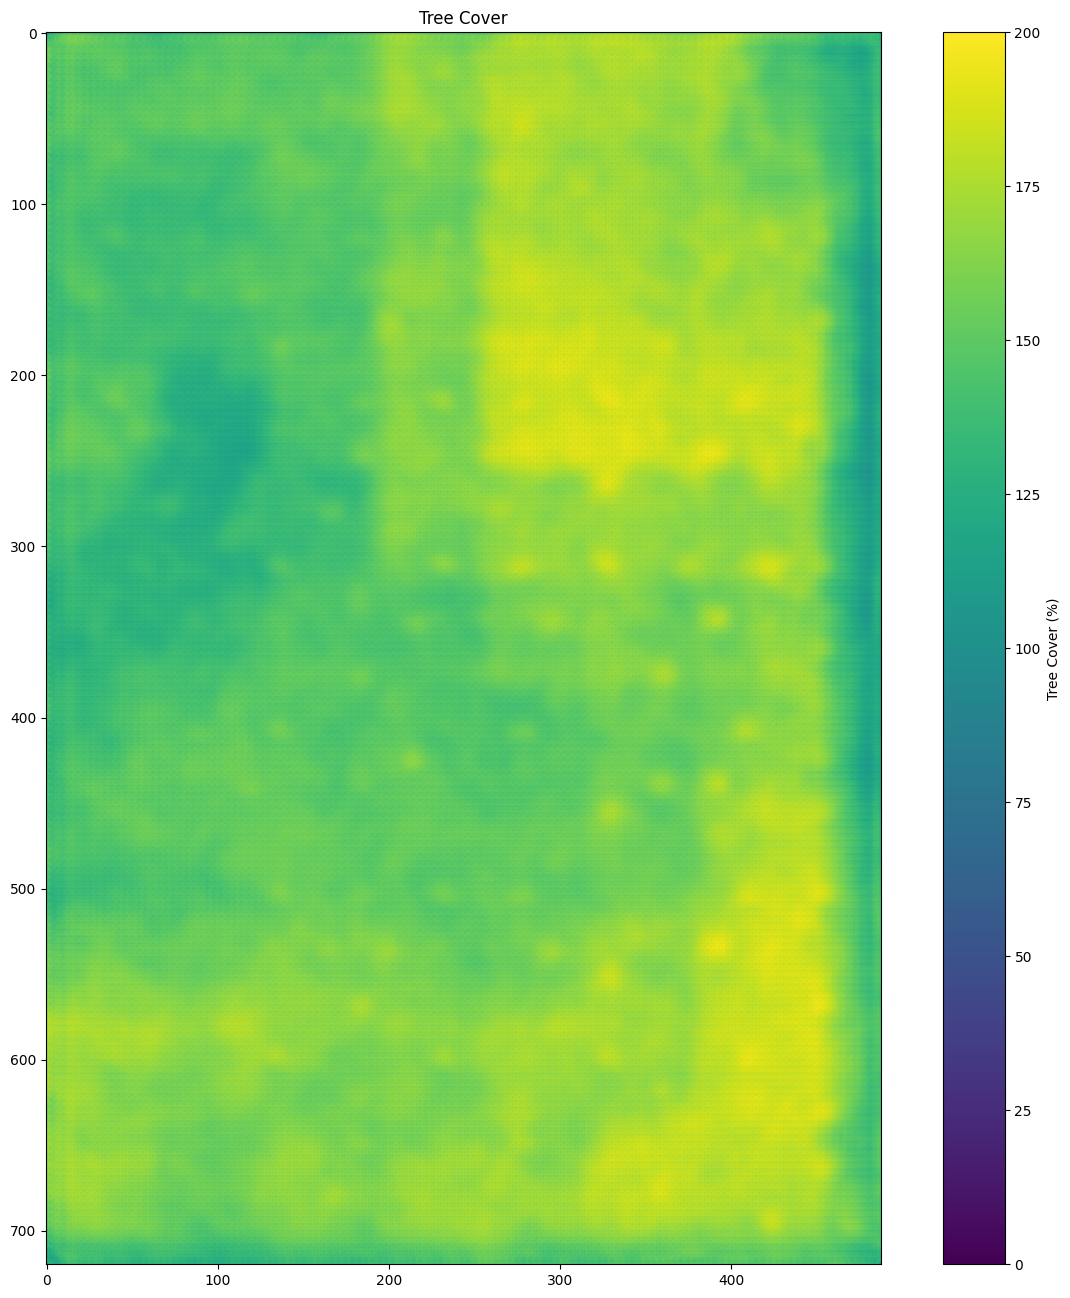

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Đọc dữ liệu từ tệp .txt
loaded_data = np.loadtxt('regress.txt', dtype=np.uint8)

# Chuyển đổi giá trị về phần trăm (0-100%)
# tree_cover_percentage = loaded_data / 255 * 100

# Tạo colormap liên tục (gradient)
cmap = plt.cm.viridis  # Dải màu liên tục từ xanh lam -> xanh lá -> vàng
norm = mcolors.Normalize(vmin=0, vmax=200)  # Chuẩn hóa giá trị từ 0% đến 100%

# Vẽ ảnh với colormap
plt.figure(figsize=(16, 16))
plt.imshow(loaded_data, cmap=cmap, norm=norm)
plt.colorbar(label="Tree Cover (%)")
plt.title("Tree Cover")
plt.axis('on')  # Tắt hiển thị trục
plt.show()

# visualize cac anh

In [2]:
import os
from PIL import Image, ImageDraw, ImageFont

def merge_images_with_labels(base_folder, output_folder):
    # Các thư mục con
    # subfolders = ['8849', '8849pp', '6003']
    subfolders = ['bosungdata_549', 'pretrain', 'full']

    # Kiểm tra font chữ
    try:
        font = ImageFont.truetype("arial.ttf", 50)
    except:
        font = ImageFont.load_default()

    folder_8849_gt = os.path.join(base_folder, subfolders[0])
    for filename in os.listdir(folder_8849_gt):
        if filename.endswith('_polygon_gt.png'):
            # Tên đầu ra dựa trên tên ảnh _polygon_gt.png
            base_name = filename.replace('_polygon_gt.png', '')
            output_path = os.path.join(output_folder, f"{base_name}_compare.png")

            # Lấy danh sách ảnh cần ghép
            images_to_merge = []
            labels = ["GT", "549 epochs (add data, pretrain)", "1520 epochs (pretrain)", '1292 epochs (full)']

            # Thêm ảnh _polygon_gt.png từ thư mục 625
            images_to_merge.append((os.path.join(folder_8849_gt, filename), "GT"))

            # Thêm ảnh _polygon_out.png từ tất cả các thư mục
            for subfolder, label in zip(subfolders, labels[1:]):
                folder_path = os.path.join(base_folder, subfolder)
                for sub_filename in os.listdir(folder_path):
                    if sub_filename.endswith('_polygon_out.png') and sub_filename.startswith(base_name):
                        images_to_merge.append((os.path.join(folder_path, sub_filename), label))

            # Mở từng ảnh và chuẩn hóa kích thước
            images = []
            for image_path, _ in images_to_merge:
                img = Image.open(image_path)
                images.append(img)

            # Kích thước chuẩn dựa trên ảnh đầu tiên
            target_width, target_height = images[0].size
            padding = 10  # Khoảng cách giữa các ảnh
            resized_images = [img.resize((target_width, target_height), Image.LANCZOS) for img in images]

            # Tính toán kích thước ảnh ghép
            total_width = target_width * len(resized_images) + padding * (len(resized_images) - 1)
            merged_image = Image.new('RGB', (total_width, target_height + 40), (255, 255, 255))

            # Ghép ảnh và thêm chú thích
            x_offset = 0
            draw = ImageDraw.Draw(merged_image)

            for img, label in zip(resized_images, labels):
                merged_image.paste(img, (x_offset, 0))
                draw.text((x_offset + 10, target_height + 5), label, fill=(0, 0, 0), font=font)
                x_offset += target_width + padding

            # Lưu ảnh ghép
            merged_image.save(output_path)
            print(f"Đã lưu ảnh ghép tại: {output_path}")

# Đường dẫn tới folder tổng và folder lưu ảnh kết quả
base_folder = "dataset_crop2/vis"
output_folder = "dataset_crop2/vis/comparepp"

# Tạo folder đầu ra nếu chưa tồn tại
os.makedirs(output_folder, exist_ok=True)

merge_images_with_labels(base_folder, output_folder)


Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID159_16_14_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID157_5_15_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID157_5_5_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID159_1_1_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID157_8_10_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID159_16_18_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID159_17_16_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID159_16_2_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID159_18_19_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID159_2_11_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID157_10_4_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID159_1_15_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID157_9_8_compare.png
Đã lưu ảnh ghép tại: dataset_crop2/vis/comparepp/ID159_15_13_co